# Lab session 1: paradigm frequencies

On veut observer les fréquences de formes fléchies, à travers les langues. Plusieures options:



1. You can code enough to read corpora files and do some stats: 
    - Head over to the UD site: https://universaldependencies.org/
    - Pick a language, download the treebank
    - Pick a POS which has inflection in this language
    - Write code to read the data, and aggregate stats.
2. You are familiar with corpora tools
    - Use a known interface, or one of the ones suggested below
    - Pick a language & POS
    - Write queries to extract inflected forms
    - Either generate the graphs online, or download the results and read them in 
3. These things sound daunting or you don't know where to start ? Follow this notebook :)

## Some tools and links

Interfaces de corpus & lexiques:
- No sketch: https://www.clarin.si/noske/
- Interface de corpus grew-match: https://match.grew.fr/
- Sketch engine: https://www.sketchengine.eu/ 
- Interface du lexique glaff: http://redac.univ-tlse2.fr/glaffoli/search/index.jsp

Quelques lexiques avec des informations de fréquence:

- Vlexique (Français): https://gitlab.com/sbeniamine/vlexique/-/tree/main?ref_type=heads
- Glaff (Français): http://redac.univ-tlse2.fr/lexiques/glaff/telechargement.html
- Latinflexi (Latin): https://github.com/matteo-pellegrini/LatInfLexi
-  

# Questions

- Combien de cases de paradigme observe-t-on pour chaque lexème ?
- Quelles est la distribution des fréquences des cases de paradigme ?
- Comment celles-ci varient d'un lexème à l'autre ?
- Quelles parties du paradigme est-il plus probable de rencontrer ?
- Avancé: Quels ensembles de cases co-occurent ?
- Quelles limites à ces mesures ?
- Quelles conséquences pour le PCFP ?

# Fréquences verbales du français

On télécharge deux lexiques: Glaff et Vlexique

In [156]:
%%bash

mkdir data/
cd data/
wget -nv http://redac.univ-tlse2.fr/lexiques/glaff/GLAFF-1.2.2.tar.bz2
tar -xf GLAFF-1.2.2.tar.bz2
wget -nv https://gitlab.com/sbeniamine/vlexique/-/raw/main/vlexique_paradigms.csv

mkdir: cannot create directory ‘data/’: File exists
2024-06-03 16:37:02 URL:http://redac.univ-tlse2.fr/lexiques/glaff/GLAFF-1.2.2.tar.bz2 [13856732/13856732] -> "GLAFF-1.2.2.tar.bz2.4" [1]
2024-06-03 16:37:10 URL:https://gitlab.com/sbeniamine/vlexique/-/raw/main/vlexique_paradigms.csv [23076073/23076073] -> "vlexique_paradigms.csv.5" [1]


In [157]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter
from itertools import combinations, chain
%matplotlib inline
sns.set_theme(style='white')

grace_cells = {'Vmcp1p-': 'cond.prs.1.pl', 'Vmcp1s-': 'cond.prs.1.sg', 'Vmcp2p-': 'cond.prs.2.pl', 'Vmcp2s-': 'cond.prs.2.sg', 'Vmcp3p-': 'cond.prs.3.pl', 'Vmcp3s-': 'cond.prs.3.sg', 'Vmmp1p-': 'imp.prs.1.pl', 'Vmmp2p-': 'imp.prs.2.pl', 'Vmmp2s-': 'imp.prs.2.sg', 'Vmif1p-': 'ind.fut.1.pl', 'Vmif1s-': 'ind.fut.1.sg', 'Vmif2p-': 'ind.fut.2.pl', 'Vmif2s-': 'ind.fut.2.sg', 'Vmif3p-': 'ind.fut.3.pl', 'Vmif3s-': 'ind.fut.3.sg', 'Vmii1p-': 'ind.ipfv.1.pl', 'Vmii1s-': 'ind.ipfv.1.sg', 'Vmii2p-': 'ind.ipfv.2.pl', 'Vmii2s-': 'ind.ipfv.2.sg', 'Vmii3p-': 'ind.ipfv.3.pl', 'Vmii3s-': 'ind.ipfv.3.sg', 'Vmip1p-': 'ind.prs.1.pl', 'Vmip1s-': 'ind.prs.1.sg', 'Vmip2p-': 'ind.prs.2.pl', 'Vmip2s-': 'ind.prs.2.sg', 'Vmip3p-': 'ind.prs.3.pl', 'Vmip3s-': 'ind.prs.3.sg', 'Vmis1p-': 'ind.pst.1.pl', 'Vmis1s-': 'ind.pst.1.sg', 'Vmis2p-': 'ind.pst.2.pl', 'Vmis2s-': 'ind.pst.2.sg', 'Vmis3p-': 'ind.pst.3.pl', 'Vmis3s-': 'ind.pst.3.sg', 'Vmn----': 'inf', 'Vmpp---': 'ptcp.prs', 'Vmps-pf': 'ptcp.pst.f.pl', 'Vmps-sf': 'ptcp.pst.f.sg', 'Vmps-pm': 'ptcp.pst.m.pl', 'Vmps-sm': 'ptcp.pst.m.sg', 'Vmsp1p-': 'sbjv.prs.1.pl', 'Vmsp1s-': 'sbjv.prs.1.sg', 'Vmsp2p-': 'sbjv.prs.2.pl', 'Vmsp2s-': 'sbjv.prs.2.sg', 'Vmsp3p-': 'sbjv.prs.3.pl', 'Vmsp3s-': 'sbjv.prs.3.sg', 'Vmsi1p-': 'sbjv.pst.1.pl', 'Vmsi1s-': 'sbjv.pst.1.sg', 'Vmsi2p-': 'sbjv.pst.2.pl', 'Vmsi2s-': 'sbjv.pst.2.sg', 'Vmsi3p-': 'sbjv.pst.3.pl', 'Vmsi3s-': 'sbjv.pst.3.sg'}

def read_vlexique(path):
    vlexique = pd.read_csv(path)
    return vlexique[((vlexique.phon_form != "#DEF#") 
                    | (vlexique.orth_form != "#DEF#"))
                    & (vlexique.frequency > 0)
    ]

def read_glaff(path):
    glaff = pd.read_csv('data/GLAFF-1.2.2/glaff-1.2.2.txt',
                        usecols=[0,1,2,13],
                        names=["orth_form", "POS", "lexeme", "frequency",], sep="|")
    glaff = glaff[glaff.POS.str.startswith("V") & glaff.frequency > 0]
    glaff["cell"] = glaff["POS"].map(grace_cells)
    return glaff

def rank_plot(df, x, y, aggfunc, title):
    df = df.groupby(x).agg(aggfunc).sort_values(y, ascending=False)
    rank_axis = f"{x} rank"
    df[rank_axis] = range(1, len(df) + 1)
    plt.close()
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1, 2, 1)
    _ = sns.lineplot(data=df, y=y, x=rank_axis)
    ax.set_title(title)
    ax = fig.add_subplot(1, 2, 2)
    _ = sns.lineplot(data=df, y=y, x=rank_axis).set(yscale="log")
    ax.set_title(f"{title} (log scale)")
    
def rank_lexemes(df, lexicon):
    return rank_plot(df, "lexeme", "cell", {"cell":"nunique"}, f"{lexicon}: number of cell per lexeme.")

def rank_cells(df, lexicon):
    return rank_plot(df, "cell", "frequency", {"frequency":"mean"}, f"{lexicon} mean cell frequency, in token.")

In [158]:
glaff = read_glaff('data/glaff-1.2.2.txt')
vlex = read_vlexique("data/vlexique_paradigms.csv")

# Combien de case de paradigme rencontre-t-on par lexème ?

- On filtre les lexiques pour exclure les formes dont la fréquence est de 0
- On classe les lexèmes par nombre de case décroissante
- On observe le nombre de cases pour chacun

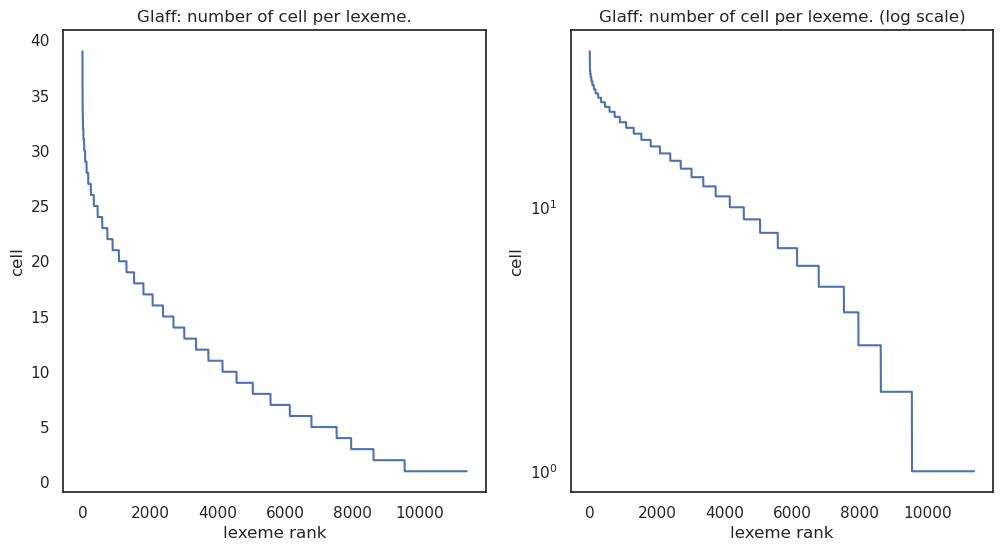

In [159]:
rank_lexemes(glaff, "Glaff")

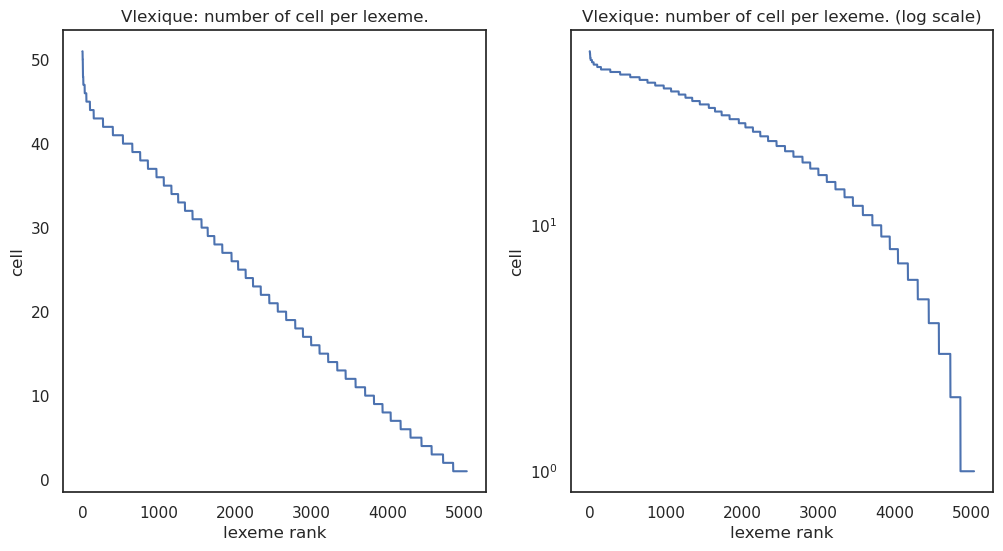

In [160]:
rank_lexemes(vlex, "Vlexique")

Une autre vue des deux distributions:

<Axes: xlabel='lexicon', ylabel='cell'>

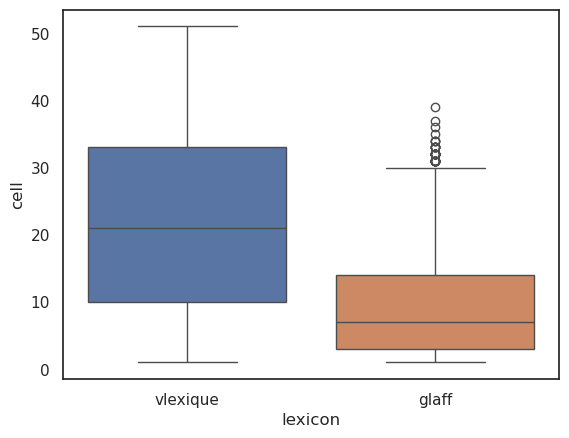

In [161]:
v_cells = vlex.groupby("lexeme").agg({"cell": "nunique"})
g_cells = glaff.groupby("lexeme").agg({"cell": "nunique"})
v_cells["lexicon"] = "vlexique"
g_cells["lexicon"] = "glaff"
cells = pd.concat((v_cells, g_cells))
sns.boxplot(cells, y="cell", x="lexicon", hue="lexicon")

# A quelle fréquence rencontre-t-on chaque case de paradigme ?

Cette fois on observe la fréquence moyenne des formes par case de paradigme (classée de la plus à la moins fréquente):

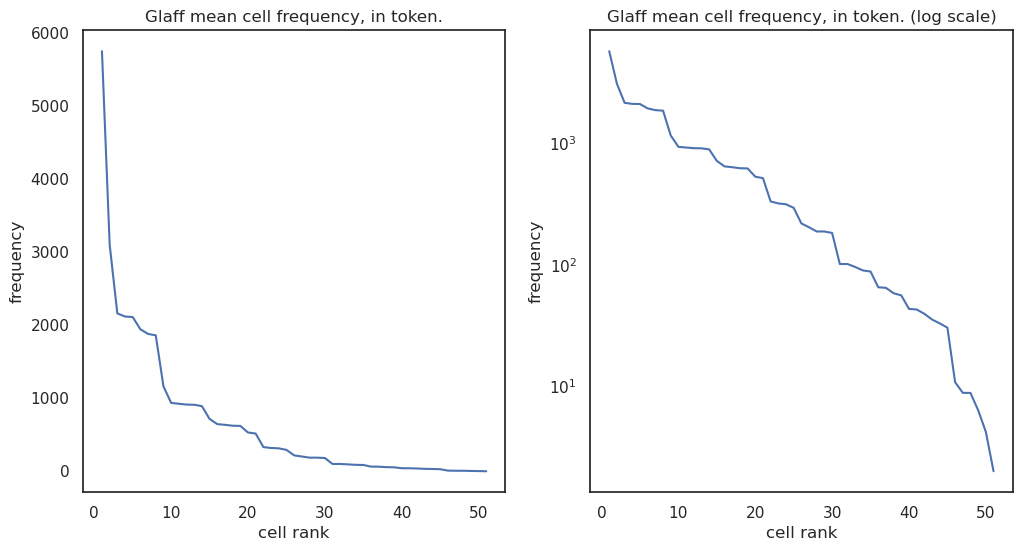

In [162]:
rank_cells(glaff, "Glaff")

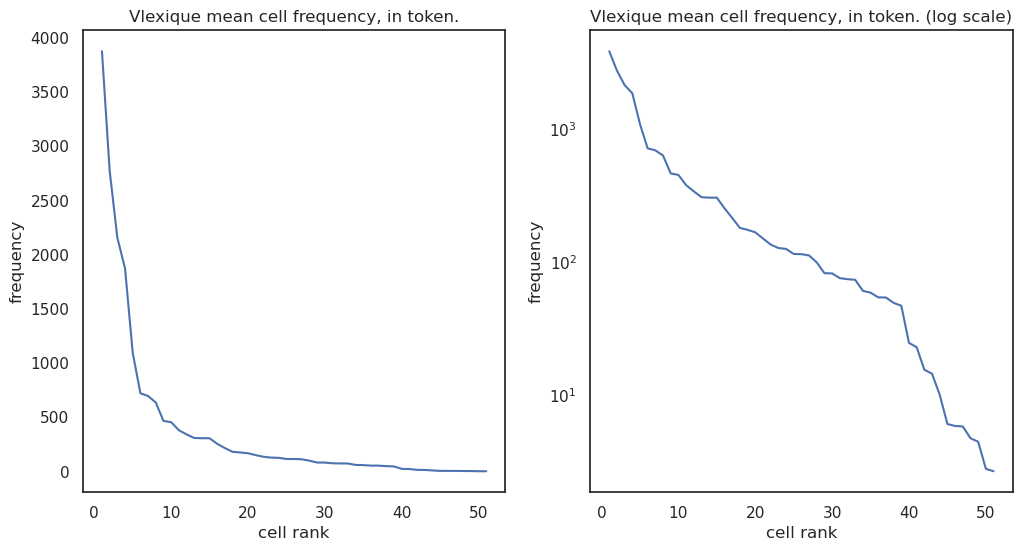

In [163]:
rank_cells(vlex, "Vlexique")

<Axes: xlabel='lexicon', ylabel='frequency'>

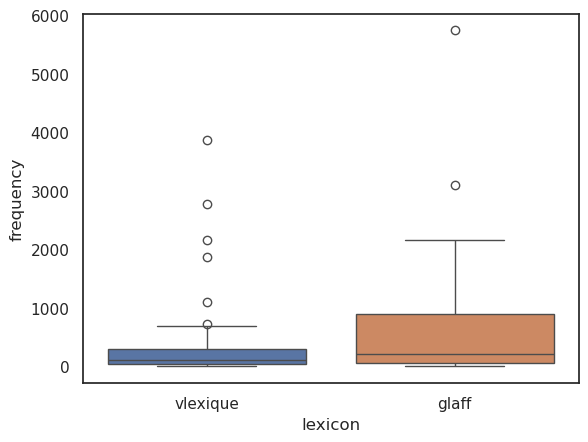

In [164]:

v_cells = vlex.groupby("cell").agg({"frequency": "mean"})
g_cells = glaff.groupby("cell").agg({"frequency": "mean"})
v_cells["lexicon"] = "vlexique"
g_cells["lexicon"] = "glaff"
cells = pd.concat((v_cells, g_cells))
sns.boxplot(cells, y="frequency", x="lexicon", hue="lexicon")

# Plus précisément, quelles parties du paradigme sont plus ou moins fréquentes ?

In [165]:
tm_order = ['ind.prs', 'ind.pst', 'ind.ipfv', 'ind.fut', 'imp.prs', 'cond.prs', 'sbjv.prs', 'sbjv.pst', 'inf', 'ptcp.prs', 'ptcp.pst.f.pl', 'ptcp.pst.f.sg', 'ptcp.pst.m.pl', 'ptcp.pst.m.sg']
pn_order = [ 'non-fini', '1.sg',  '2.sg', '3.sg', '1.pl','2.pl', '3.pl']

to_index = dict(zip(tm_order, range(len(tm_order))))
to_index.update(dict(zip(pn_order, range(len(pn_order)))))
def split_cell(cell):
    if cell == "inf" or cell.startswith("ptcp."):
        return (cell, "non-fini")
    mode, tense, pers, num = cell.split(".")
    return mode+"."+tense, pers+"."+num
    
def to_coords(cell):
    a, b = split_cell(cell)
    return to_index[a], to_index[b]

def to_matrix(cells_freqs):
    m = np.zeros((len(tm_order), len(pn_order)))
    idx = [to_coords(c) for c in cells_freqs.index]
    m[tuple(np.array(idx).T)] = cells_freqs.values[:,0]
    m[range(7), 0] = np.nan
    m[range(7,14), 1:] = np.nan
    return m

def cell_heatmap(df, lexicon):
    total_lexs = df.lexeme.nunique()
    freqs = df.groupby("cell").agg({"lexeme":"nunique"}) / total_lexs * 100
    sns.heatmap(to_matrix(freqs), vmin=0, vmax=100, xticklabels=pn_order, yticklabels=tm_order, cmap="Reds")
    plt.title(f"{lexicon}: % de lexèmes par case")
    
    
def cell_freq_heatmap(df, lexicon):
    freqs = df.groupby("cell").agg({"frequency":"mean"})
    sns.heatmap(to_matrix(freqs), xticklabels=pn_order, yticklabels=tm_order, cmap="Reds")
    plt.title(f"{lexicon}: fréquence moyenne de chaque case")

Dans les cartes de chaleur ci-dessous, on observe d'abord le pourcentage des lexèmes de chaque lexique comportant chaque case du paradigme:

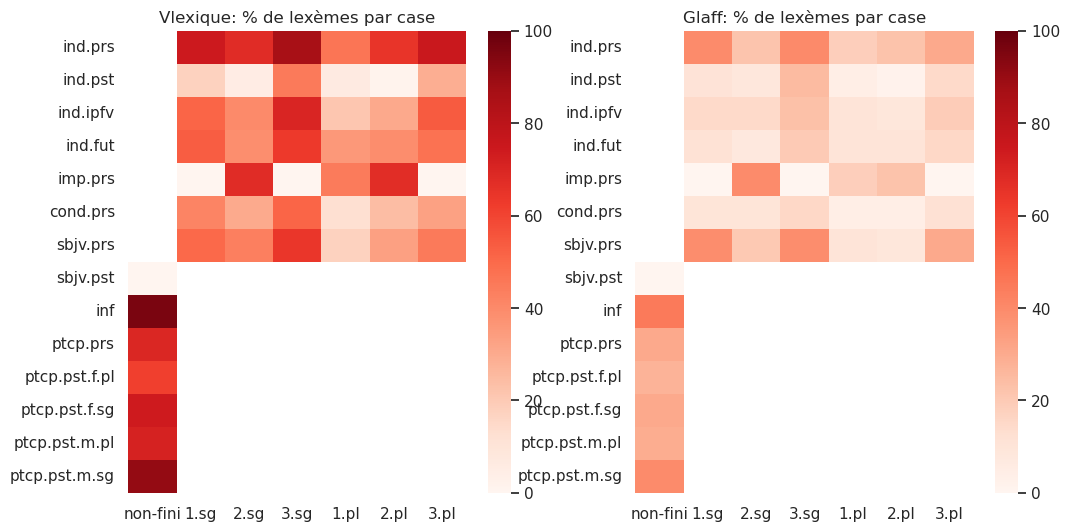

In [166]:

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)
cell_heatmap(vlex, "Vlexique")
ax = fig.add_subplot(1, 2, 2)
cell_heatmap(glaff,"Glaff")

Ci-dessous on compare la fréquence absolue de chaque case dans chaque lexique:

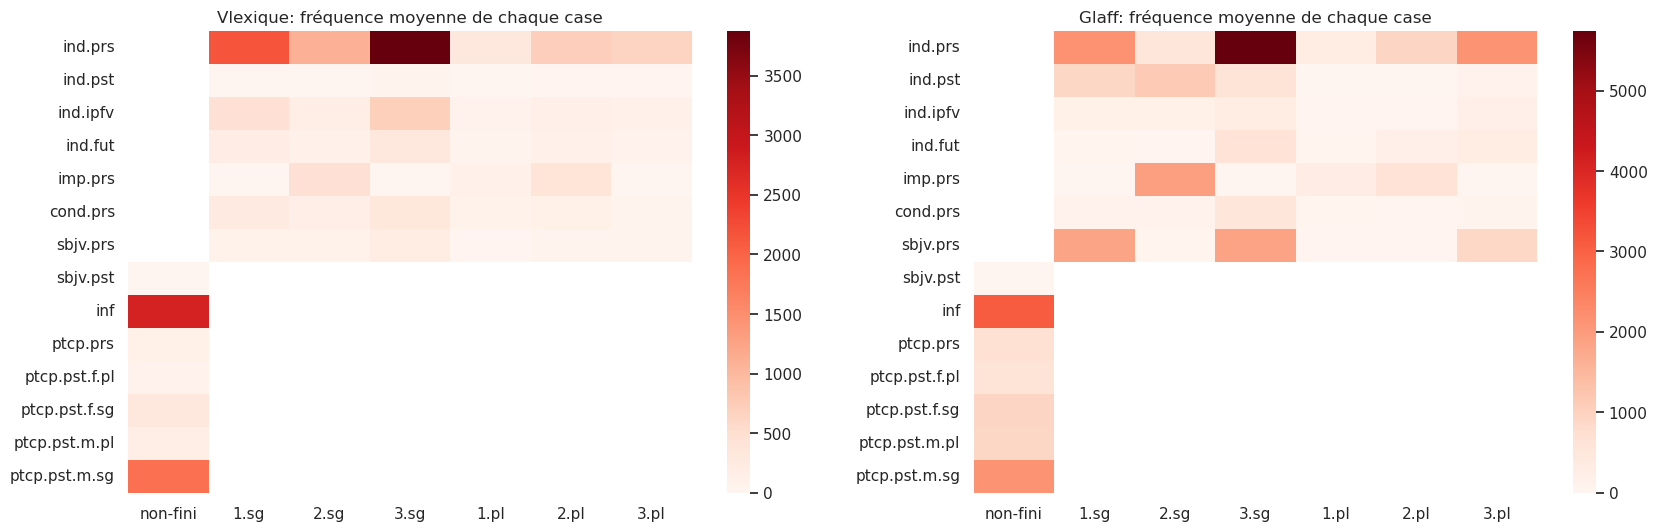

In [167]:

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1, 2, 1)
cell_freq_heatmap(vlex, "Vlexique")
ax = fig.add_subplot(1, 2, 2)
cell_freq_heatmap(glaff, "Glaff")

Ci-dessous, on observe les distributions de co-occurences entre paires de cases:

In [168]:
def cooccurences_cells(df):
    groups = df.groupby("lexeme")
    cell_labels =df.cell.unique()
    cells = groups.agg({"cell": lambda cells:set(cells.values)}).values
    counts = Counter([pair for cset in cells for pair in combinations(sorted(cset[0]),2)])
    res = {a: {b:counts[a,b] + counts[b,a] for b in cell_labels} for a in cell_labels}
    sns.clustermap(pd.DataFrame(res), xticklabels=cell_labels, yticklabels=cell_labels, cmap="Reds")

/home/sacha/anaconda3/envs/Labs/lib/python3.8/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/sacha/anaconda3/envs/Labs/lib/python3.8/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


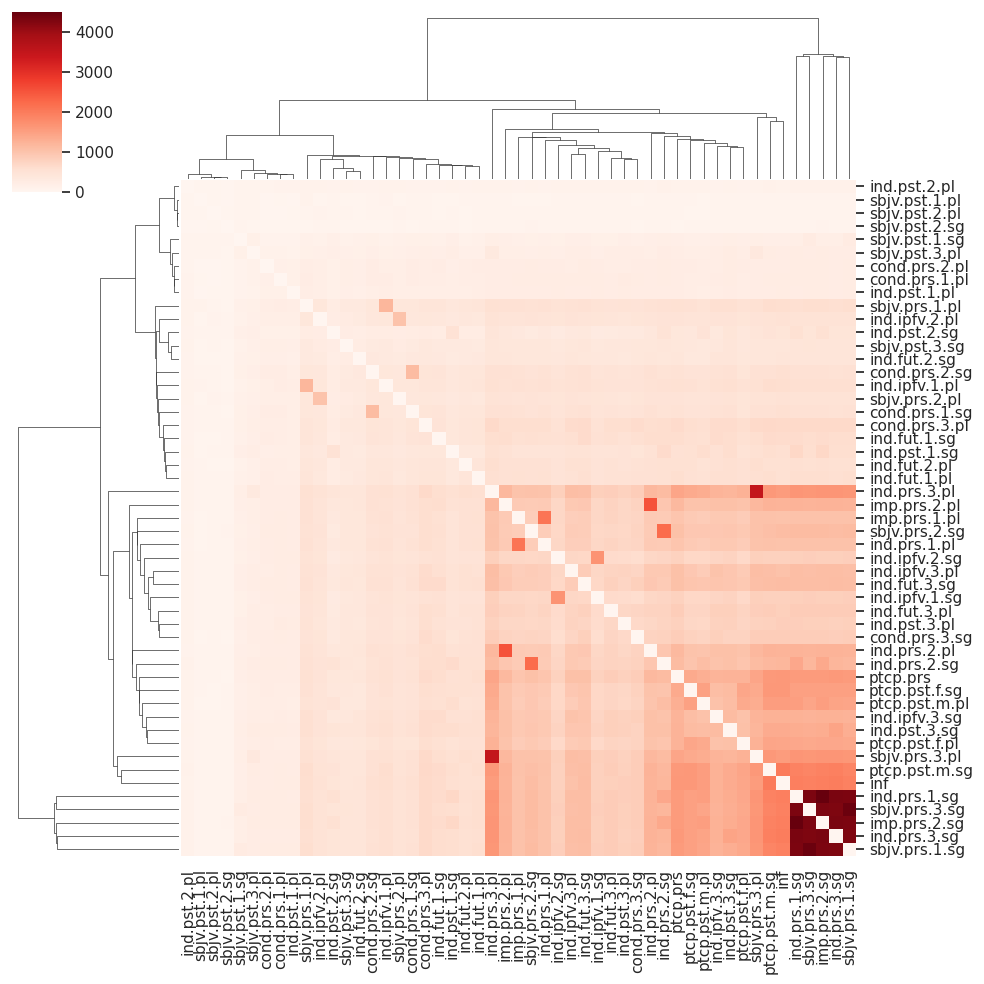

In [169]:
cooccurences_cells(glaff)

/home/sacha/anaconda3/envs/Labs/lib/python3.8/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/sacha/anaconda3/envs/Labs/lib/python3.8/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


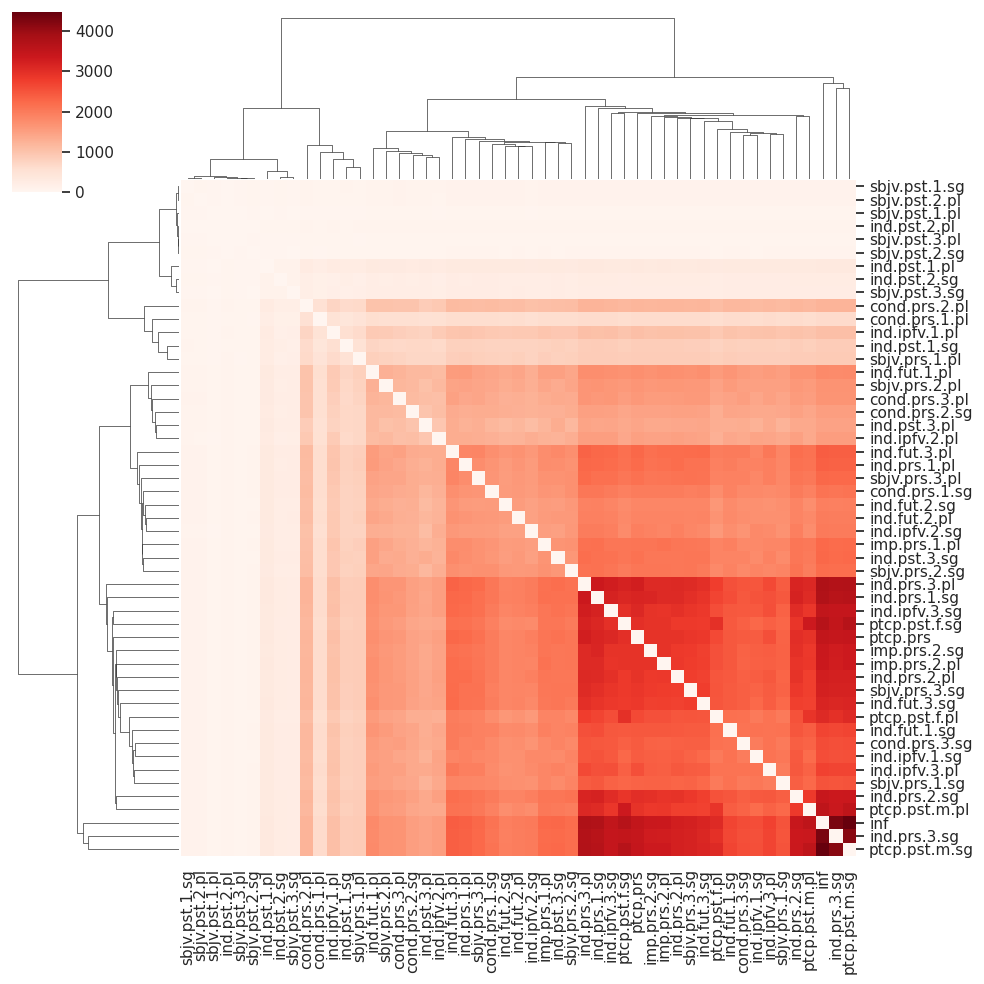

In [170]:

cooccurences_cells(vlex)